1. Create a Anaconda environment 'pyspark'
2. !pip install pyspark ( this package will directly communicate with Spark)
3. Install Spark in your machine (from here: https://spark.apache.org/downloads.html). I installed spark-2.2.0-bin-hadoop2.6.tgz
4. In your .bash_profile set the following
    export SPARK_HOME=/Users/anindyas/work/spark-2.2.0-bin-hadoop2.6
    PATH=\$SPARK_HOME/bin:$PATH
    export PATH

    export PATH="/Users/anindyas/anaconda/envs/pyspark/bin:$PATH"
    
    There is further better way to set the environment variables but for now it is fine.
5. start you jupyter notebook from Anaconda Navigator in pyspark environment

In [1]:
import os
import pandas

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
!which python

/home/ubuntu/anaconda3/envs/pyspark/bin/python


In [5]:
# creating the SparkContext in Spark 1.6 way
#sc = SparkContext(master='local[*]', appName='pyspark-jupyter', sparkHome=os.environ['SPARK_HOME'])
#sc

In [6]:
# creating the SparkContext Spark 2.2.0 way
spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("pyspark-jupyter")
         .getOrCreate())
#spark = (SparkSession
#         .builder
#         .master("local[*]")
#         .appName("pyspark-jupyter")
#         .config("spark.some.config.option", "some-value")
#         .getOrCreate())

In [7]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-jupyter>

In [8]:
sc.sparkHome, sc.master, sc.appName

(None, 'local[*]', 'pyspark-jupyter')

# Loading Data Into Spark RDD

In [9]:
AUCTION_DATA_PATH = 'data/auction.csv'

## Load Data as Strings in unnamed Rows

Load Data into RDD from a csv. Note here we did not provide any schema hence all the rows would be loaded as Strings

In [10]:
auctionRDD = sc.textFile(AUCTION_DATA_PATH).map(lambda line: line.split(","))

In [11]:
auctionRDD.first()

['8213034705', '95', '2.927373', 'jake7870', '0', '95', '117.5', 'xbox', '3']

In [12]:
auctionRDD.count()

10654

### Let's collect the first two bids

In [13]:
list(map(lambda record: record[1], auctionRDD.take(2)))

['95', '115']

## Load Data as Strings but as named tuples

We will see below why it is more convenient.

In [14]:
from collections import namedtuple

In [15]:
# auctionid - unique identifier of an auction
# bid - the proxy bid placed by a bidder
# bidtime - the time (in days) that the bid was placed, from the start of the auction
# bidder - eBay username of the bidder
# bidderrate - eBay feedback rating of the bidder
# openbid - the opening bid set by the seller
# price - the closing price that the item sold for (equivalent to the second highest bid + an increment)
# item -  the name of the item
# daystolive - how long the bid is alive
Auction = namedtuple("Auction", ["auctionid", "bid", "bidtime", "bidder", "bidderrate", "openbid", "price", "item", "daystolive"])

In [16]:
auctionRDD2 = sc.textFile(AUCTION_DATA_PATH).map(lambda line: line.split(","))

In [17]:
auctionRDD2 = auctionRDD.map(lambda rec: Auction(rec[0], rec[1], rec[2], rec[3], rec[4], rec[5], rec[6], rec[7], rec[8]))

In [18]:
auctionRDD2.first()

Auction(auctionid='8213034705', bid='95', bidtime='2.927373', bidder='jake7870', bidderrate='0', openbid='95', price='117.5', item='xbox', daystolive='3')

Observe here, instead of simple strings, each row is a named tuple now.

### Let's collect the first two bids

We can collect the first two bids now by specifying the field name of the tuple instead of field index as above. This is more convenient.

In [19]:
list(map(lambda auction: auction.bid, auctionRDD2.take(2)))

['95', '115']

## Converting a SparkRDD into SparkDF

In [20]:
# toDF method is a monkey patch executed inside SparkSession (SQLContext constructor in 1.x) constructor so to be able to use it 
# you have to create a SQLContext (or SparkSession) first
#from pyspark.sql import SparkSession, SQLContext
#spark = SparkSession(sc)

In [21]:
auctionDF = auctionRDD.toDF()

In [22]:
auctionDF.show(5)

+----------+-----+--------+--------------+---+---+-----+----+---+
|        _1|   _2|      _3|            _4| _5| _6|   _7|  _8| _9|
+----------+-----+--------+--------------+---+---+-----+----+---+
|8213034705|   95|2.927373|      jake7870|  0| 95|117.5|xbox|  3|
|8213034705|  115|2.943484| davidbresler2|  1| 95|117.5|xbox|  3|
|8213034705|  100|2.951285|gladimacowgirl| 58| 95|117.5|xbox|  3|
|8213034705|117.5|2.998947|       daysrus| 10| 95|117.5|xbox|  3|
|8213060420|    2|0.065266|    donnie4814|  5|  1|  120|xbox|  3|
+----------+-----+--------+--------------+---+---+-----+----+---+
only showing top 5 rows



Let's convert the RDD with named tuple to DF

In [23]:
auctionDF2 = auctionRDD2.toDF()

In [24]:
auctionDF2.show(5)

+----------+-----+--------+--------------+----------+-------+-----+----+----------+
| auctionid|  bid| bidtime|        bidder|bidderrate|openbid|price|item|daystolive|
+----------+-----+--------+--------------+----------+-------+-----+----+----------+
|8213034705|   95|2.927373|      jake7870|         0|     95|117.5|xbox|         3|
|8213034705|  115|2.943484| davidbresler2|         1|     95|117.5|xbox|         3|
|8213034705|  100|2.951285|gladimacowgirl|        58|     95|117.5|xbox|         3|
|8213034705|117.5|2.998947|       daysrus|        10|     95|117.5|xbox|         3|
|8213060420|    2|0.065266|    donnie4814|         5|      1|  120|xbox|         3|
+----------+-----+--------+--------------+----------+-------+-----+----+----------+
only showing top 5 rows



See the difference in the headings that are generated in the above two cases when we convert the RDD to DF.

# Loading Data Into Spark DataFrames

Instead of going through a RDD we can also load the data as a DataFrame directly.

## Load Data into SparkDF without infering the Schema i.e. all columns will be treated as String

In [25]:
auctionDF3 = spark.read.csv(AUCTION_DATA_PATH, inferSchema=False)

In [26]:
type(auctionDF3)

pyspark.sql.dataframe.DataFrame

In [27]:
auctionDF3

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string]

In [28]:
auctionDF3.show(5)

+----------+-----+--------+--------------+---+---+-----+----+---+
|       _c0|  _c1|     _c2|           _c3|_c4|_c5|  _c6| _c7|_c8|
+----------+-----+--------+--------------+---+---+-----+----+---+
|8213034705|   95|2.927373|      jake7870|  0| 95|117.5|xbox|  3|
|8213034705|  115|2.943484| davidbresler2|  1| 95|117.5|xbox|  3|
|8213034705|  100|2.951285|gladimacowgirl| 58| 95|117.5|xbox|  3|
|8213034705|117.5|2.998947|       daysrus| 10| 95|117.5|xbox|  3|
|8213060420|    2|0.065266|    donnie4814|  5|  1|  120|xbox|  3|
+----------+-----+--------+--------------+---+---+-----+----+---+
only showing top 5 rows



In [29]:
# print the schema. Spark has given some default column names
auctionDF3.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)



## Load Data into SparkDF letting Spark infer the Schema by itself

We can isntruct Spark to infer the schema determine the correct data type of the columns by itslef, we don't provide any.

In [30]:
auctionDF4 = spark.read.csv(AUCTION_DATA_PATH, inferSchema=True)

In [31]:
type(auctionDF4)

pyspark.sql.dataframe.DataFrame

In [32]:
auctionDF4

DataFrame[_c0: bigint, _c1: double, _c2: double, _c3: string, _c4: int, _c5: double, _c6: double, _c7: string, _c8: int]

In [33]:
auctionDF4.show(5)

+----------+-----+--------+--------------+---+----+-----+----+---+
|       _c0|  _c1|     _c2|           _c3|_c4| _c5|  _c6| _c7|_c8|
+----------+-----+--------+--------------+---+----+-----+----+---+
|8213034705| 95.0|2.927373|      jake7870|  0|95.0|117.5|xbox|  3|
|8213034705|115.0|2.943484| davidbresler2|  1|95.0|117.5|xbox|  3|
|8213034705|100.0|2.951285|gladimacowgirl| 58|95.0|117.5|xbox|  3|
|8213034705|117.5|2.998947|       daysrus| 10|95.0|117.5|xbox|  3|
|8213060420|  2.0|0.065266|    donnie4814|  5| 1.0|120.0|xbox|  3|
+----------+-----+--------+--------------+---+----+-----+----+---+
only showing top 5 rows



In [34]:
auctionDF4.printSchema()

root
 |-- _c0: long (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: integer (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: integer (nullable = true)



Observe here, that Spark has smartly infered the most suitable data types for the columns by looking at the data.

## Load Data into SparkDF using user defined Schema

In [35]:
from pyspark.sql.types import *

In [36]:
schema = StructType([
    StructField("auctionid", StringType(), nullable=True),
    StructField("bid", FloatType(), nullable=True),
    StructField("bidtime", FloatType(), nullable=True),
    StructField("bidder", StringType(), nullable=True),
    StructField("bidderrate", IntegerType(), nullable=True),
    StructField("openbid", FloatType(), nullable=True),
    StructField("price", FloatType(), nullable=True),
    StructField("item", StringType(), nullable=True),
    StructField("daystolive", IntegerType(), nullable=True)]
)

In [37]:
auctionDF5 = spark.read.csv(AUCTION_DATA_PATH, schema=schema)

In [38]:
type(auctionDF5)

pyspark.sql.dataframe.DataFrame

In [39]:
auctionDF5

DataFrame[auctionid: string, bid: float, bidtime: float, bidder: string, bidderrate: int, openbid: float, price: float, item: string, daystolive: int]

In [40]:
auctionDF5.show(5)

+----------+-----+--------+--------------+----------+-------+-----+----+----------+
| auctionid|  bid| bidtime|        bidder|bidderrate|openbid|price|item|daystolive|
+----------+-----+--------+--------------+----------+-------+-----+----+----------+
|8213034705| 95.0|2.927373|      jake7870|         0|   95.0|117.5|xbox|         3|
|8213034705|115.0|2.943484| davidbresler2|         1|   95.0|117.5|xbox|         3|
|8213034705|100.0|2.951285|gladimacowgirl|        58|   95.0|117.5|xbox|         3|
|8213034705|117.5|2.998947|       daysrus|        10|   95.0|117.5|xbox|         3|
|8213060420|  2.0|0.065266|    donnie4814|         5|    1.0|120.0|xbox|         3|
+----------+-----+--------+--------------+----------+-------+-----+----+----------+
only showing top 5 rows



In [41]:
auctionDF5.printSchema()

root
 |-- auctionid: string (nullable = true)
 |-- bid: float (nullable = true)
 |-- bidtime: float (nullable = true)
 |-- bidder: string (nullable = true)
 |-- bidderrate: integer (nullable = true)
 |-- openbid: float (nullable = true)
 |-- price: float (nullable = true)
 |-- item: string (nullable = true)
 |-- daystolive: integer (nullable = true)



In [42]:
auctionDF5.show()

+----------+-----+--------+--------------+----------+-------+-----+----+----------+
| auctionid|  bid| bidtime|        bidder|bidderrate|openbid|price|item|daystolive|
+----------+-----+--------+--------------+----------+-------+-----+----+----------+
|8213034705| 95.0|2.927373|      jake7870|         0|   95.0|117.5|xbox|         3|
|8213034705|115.0|2.943484| davidbresler2|         1|   95.0|117.5|xbox|         3|
|8213034705|100.0|2.951285|gladimacowgirl|        58|   95.0|117.5|xbox|         3|
|8213034705|117.5|2.998947|       daysrus|        10|   95.0|117.5|xbox|         3|
|8213060420|  2.0|0.065266|    donnie4814|         5|    1.0|120.0|xbox|         3|
|8213060420|15.25|0.123218|   myreeceyboy|        52|    1.0|120.0|xbox|         3|
|8213060420|  3.0|0.186539|  parakeet2004|         5|    1.0|120.0|xbox|         3|
|8213060420| 10.0| 0.18669|  parakeet2004|         5|    1.0|120.0|xbox|         3|
|8213060420|24.99|0.187049|  parakeet2004|         5|    1.0|120.0|xbox|    

In [43]:
# Statistical caluclations on the DataFrame
auctionDF5.describe(['bid', 'bidderrate', 'daystolive']).show()

+-------+------------------+------------------+------------------+
|summary|               bid|        bidderrate|        daystolive|
+-------+------------------+------------------+------------------+
|  count|             10654|             10654|             10654|
|   mean|207.93610752026177| 31.98216632250798|5.9384268819222825|
| stddev|323.36573278308225|120.67889820331808|1.5850851356670426|
|    min|              0.01|                -4|                 3|
|    max|            5400.0|              3140|                 7|
+-------+------------------+------------------+------------------+



In [44]:
# How many unique bidders are there?
auctionDF5.select('bidder').distinct().count()

3385

In [45]:
# calculate the 25, 50 and 75 percentile values
auctionDF5.approxQuantile(['bidtime'], [.25, .5, .75], 0)

[[1.9469200372695923, 4.130959987640381, 6.444029808044434]]

## Convert a Spark Dataframe into Pandas DataFrame

In [46]:
auction_pdf = auctionDF5.toPandas()

In [47]:
auction_pdf.head(5)

,auctionid,bid,bidtime,bidder,bidderrate,openbid,price,item,daystolive
0,8213034705,95.0,2.927373,jake7870,0,95.0,117.5,xbox,3
1,8213034705,115.0,2.943484,davidbresler2,1,95.0,117.5,xbox,3
2,8213034705,100.0,2.951285,gladimacowgirl,58,95.0,117.5,xbox,3
3,8213034705,117.5,2.998947,daysrus,10,95.0,117.5,xbox,3
4,8213060420,2.0,0.065266,donnie4814,5,1.0,120.0,xbox,3


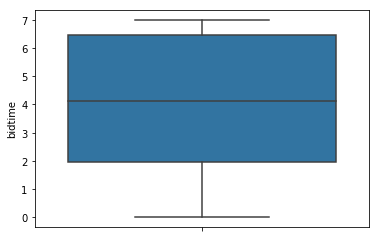

In [48]:
sns.boxplot(auction_pdf['bidtime'], orient='v'); # check if it matches with the percentile values obtained from Spark DF

In [49]:
user_purchase_df = sc.textFile("data/user_purchase_history.csv").map(lambda line: line.split(",")).map(lambda record: (record[0], record[1], record[2]))

In [50]:
# let's count the number of purchases
numPurchases = user_purchase_df.count()
numPurchases

5

In [51]:
# let's count how many unique users made purchases
uniqueUsers = user_purchase_df.map(lambda record: record[0]).distinct().count()
# let's sum up our total revenue
totalRevenue = user_purchase_df.map(lambda record: float(record[2])).sum()
# let's find our most popular product
products = user_purchase_df.map(lambda record: (record[1], 1.0)).reduceByKey(lambda a, b: a + b).collect()
mostPopular = sorted(products, key=lambda x: x[1], reverse=True)[0]

In [52]:
print("Total purchases: %d" % numPurchases)
print("Unique users: %d" % uniqueUsers)
print("Total revenue: %2.2f" % totalRevenue)
print("Most popular product: %s with %d purchases" % (mostPopular[0], mostPopular[1]))

Total purchases: 5
Unique users: 4
Total revenue: 39.91
Most popular product: iPhone Cover with 2 purchases


In [53]:
spark.stop()